In [2]:
import pandas as pd
data = pd.read_csv('unmatch_shops.csv')

In [3]:
data = data.groupby('shop_index').sum()
data.describe()

,Unnamed: 0,decorated_indicator,manage_shop_indicator,officialstore_indicator,preferred_shop_indicator,crossborder_indicator,shop_category,new_seller_flag,seller_centre_login_L30D,shop_sku_number,shop_follower_number,shop_L180D_order,weighted_shop_rating,performance_date,masked_item_impression,masked_order,masked_shop_page_view,masked_shop_click_from_search,masked_campaign_tab_click,masked_other_tab_click
count,7.980000e+03,7980.0,7980.000000,7980.000000,7980.000000,7980.000000,7980.000000,7980.000000,7980.000000,7.980000e+03,7.980000e+03,7.980000e+03,7980.000000,7980.0,7.980000e+03,7.980000e+03,7980.000000,7.980000e+03,7980.0,7980.000000
mean,2.544294e+06,0.0,0.159649,0.019298,0.291228,2.331579,111.375439,2.412281,111.950877,5.733361e+04,3.901551e+04,4.751622e+04,59.711852,105.0,5.917396e+09,1.464608e+07,1015.078697,1.325045e+03,154.0,935.678321
std,1.461768e+06,0.0,1.486565,0.519458,1.998219,5.216249,93.987426,5.287375,120.911936,8.547534e+04,2.028701e+05,3.848751e+05,8.090014,0.0,1.907460e+11,8.282347e+08,8139.463510,2.805431e+04,0.0,4267.602120
min,9.100000e+01,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,3.458000e+03,1.360800e+04,5.670000e+03,0.000000,105.0,0.000000e+00,0.000000e+00,0.000000,1.400000e+01,154.0,218.578947
25%,1.293992e+06,0.0,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,14.000000,1.547000e+04,1.360800e+04,5.670000e+03,56.000000,105.0,1.484532e+05,0.000000e+00,0.000000,3.598684e+01,154.0,297.171053
50%,2.551241e+06,0.0,0.000000,0.000000,0.000000,0.000000,98.000000,0.000000,56.000000,3.333400e+04,1.390200e+04,5.670000e+03,58.263158,105.0,4.231453e+06,1.000000e+00,0.000000,1.174474e+02,154.0,406.736842
75%,3.798158e+06,0.0,0.000000,0.000000,0.000000,0.000000,182.000000,0.000000,154.000000,7.583800e+04,1.886850e+04,2.514400e+04,66.052632,105.0,3.913578e+07,9.900000e+01,4.000000,4.033947e+02,154.0,647.000000
max,5.099185e+06,0.0,14.000000,14.000000,14.000000,14.000000,280.000000,14.000000,420.000000,1.516046e+06,1.102139e+07,2.371736e+07,70.000000,105.0,1.277923e+13,7.038493e+10,423806.000000,2.054703e+06,154.0,224244.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7980 entries, 119700 to 1486803240
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     7980 non-null   int64  
 1   decorated_indicator            7980 non-null   int64  
 2   manage_shop_indicator          7980 non-null   int64  
 3   officialstore_indicator        7980 non-null   int64  
 4   preferred_shop_indicator       7980 non-null   int64  
 5   crossborder_indicator          7980 non-null   int64  
 6   shop_category                  7980 non-null   int64  
 7   new_seller_flag                7980 non-null   int64  
 8   seller_centre_login_L30D       7980 non-null   int64  
 9   shop_sku_number                7980 non-null   int64  
 10  shop_follower_number           7980 non-null   int64  
 11  shop_L180D_order               7980 non-null   int64  
 12  weighted_shop_rating           7980 n

In [5]:
# data = data.drop(columns=['Unnamed: 0','decorated_indicator'])
# data
X = data.drop("masked_order",1)
y = data["masked_order"]

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
#apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=f_regression, k=5)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 5 best features

                            Specs         Score
12         masked_item_impression  21264.851884
9                shop_L180D_order  16949.870327
16         masked_other_tab_click   7867.965443
8            shop_follower_number   6961.545064
2        preferred_shop_indicator     84.991553
14  masked_shop_click_from_search     57.416127
0           manage_shop_indicator     25.002030
6        seller_centre_login_L30D     14.976852
4                   shop_category      5.914210
3           crossborder_indicator      3.510023


C:\Users\65843\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\65843\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:306: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


[2.40517378e-04 1.10388483e-05 6.94908130e-04 3.04226507e-05
 2.12468218e-04 2.04995848e-06 7.80373161e-05 1.25352112e-02
 1.80855529e-01 4.09282537e-01 3.37056742e-08 0.00000000e+00
 2.62704034e-01 1.77690387e-03 2.77615649e-03 0.00000000e+00
 1.28800152e-01]


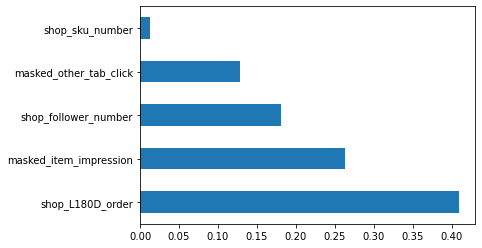

In [35]:
from sklearn.ensemble import RandomForestRegressor 
from matplotlib import pyplot as plt

model = RandomForestRegressor ()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances 
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [27]:
from sklearn.feature_selection import RFE
# Feature extraction
model = RandomForestRegressor()
rfe = RFE(model, 5)
fit = rfe.fit(X, y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

C:\Users\65843\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Num Features: 5
Selected Features: [False False False False False False False  True  True  True False False
  True False False False  True]
Feature Ranking: [ 5  7  6  9  4 11  8  1  1  1 10 12  1  2  3 13  1]


Optimal number of features : 3


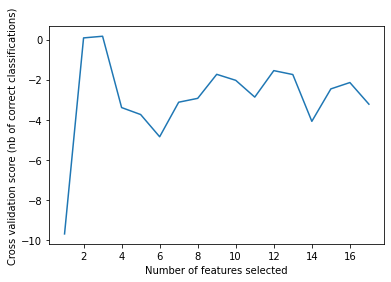

In [36]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from matplotlib import pyplot as plt

# Instantiate RFECV visualizer with a random forest regressor
rfecv = RFECV(RandomForestRegressor())

rfecv.fit(X, y) # Fit the data to the visualizer

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

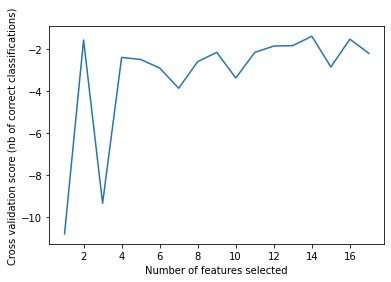

In [33]:
from matplotlib import pyplot as plt

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [13]:
#prediction on unmatched data with features selected
data.head()
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import numpy as np
lm=linear_model.LinearRegression()features = ['shop_L180D_order','masked_item_impression','masked_other_tab_click','shop_follower_number']


X = data[features]
y = data['masked_order']
# print(X.shape,y.shape)
model = lm.fit(X,y)
print(model.intercept_, model.coef_)
scores = - cross_val_score(lm, X, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(scores))

-9435679.515345858 [ 1.00081043e+03  2.71670688e-03 -2.94604844e+04 -3.07141142e+02]
6.31491690066399e+17


In [14]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn import metrics
my_model = RandomForestRegressor()
my_model.fit(X_train,y_train)

predicted_prices = my_model.predict(X_test)
print(predicted_prices)
print("MSE for Random Forest Regressor:",metrics.mean_squared_log_error(predicted_prices, y_test))
# print(metrics.mean_squared_log_error(predicted_prices, y_test))

[3.27132138e+06 9.70000000e-01 1.00000000e-01 ... 0.00000000e+00
 5.10000000e-01 7.83620000e+02]
MSE for Random Forest Regressor: 5.4100820855128315


In [10]:
#MLR
from sklearn import model_selection
import pandas as pd
import numpy as np
import statsmodels.api as sm

train, test = model_selection.train_test_split(data, test_size = 0.2, random_state=1234)
# features = ['shop_L180D_order','masked_item_impression','masked_other_tab_click','shop_follower_number']
df = data[['shop_L180D_order','masked_item_impression','masked_other_tab_click','shop_follower_number','masked_order']]
df
model=sm.formula.ols('masked_order~shop_L180D_order+masked_item_impression+masked_other_tab_click+shop_follower_number',data=df).fit()
print('模型的偏回归系数分别为：',model.params)

模型的偏回归系数分别为： Intercept                -9.435680e+06
shop_L180D_order          1.000810e+03
masked_item_impression    2.716707e-03
masked_other_tab_click   -2.946048e+04
shop_follower_number     -3.071411e+02
dtype: float64


In [11]:
test_x = df.drop('masked_order',axis=1)
pred = model.predict(exog = test_x)
pd.DataFrame({'Prediction':pred,'Actual':test.masked_order})

,Prediction,Actual
shop_index,,
119700,5.018839e+07,NaN
215775,6.843805e+06,100175.0
406305,-7.791038e+07,NaN
505260,-4.443017e+06,NaN
1004355,5.403027e+07,NaN
...,...,...
1484964585,-2.068443e+07,NaN
1485915030,-2.065258e+07,NaN
1486048005,-1.535226e+07,NaN


In [14]:
#模型的F检验
import numpy as np

#计算建模数据中的因变量的均值
ybar=train.masked_order.mean()

#统计变量个数和观测个数
p=model.df_model
n=train.shape[0]

#计算回归离差平方和
RSS=np.sum((model.fittedvalues-ybar)**2)

#计算误差平方和
ESS=np.sum(model.resid**2)

#计算F统计量的值
F=(RSS/p)/(ESS/(n-p-1))

print('F统计量的值：',F)
#对比结果

from scipy.stats import f

#计算F分布的理论值
F_Theory=f.ppf(q=0.95,dfn=p,dfd=n-p-1)
print('F分布的理论值为：',F_Theory)

#model summary
model.summary()


F统计量的值： 5015.175736542297
F分布的理论值为： 2.3733248122893413


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           masked_order   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     6269.
Date:                Fri, 29 Oct 2021   Prob (F-statistic):               0.00
Time:                        09:29:36   Log-Likelihood:            -1.6952e+05
No. Observations:                7980   AIC:                         3.390e+05
Df Residuals:                    7975   BIC:                         3.391e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -9.436e+06   4.85e+06     -1.947      0.052   -1.89e+07    6.47e+04
shop_L180D_order        1000.8104     31.172     32.106      0.000     939.705    1061.916
masked_item_impression     0.0027   5.34e-05     50.890      0.000       0.003       0.003
masked_other_tab_click -2.946e+04   2340.510    -12.587      0.000    -3.4e+04   -2.49e+04
shop_follower_number    -307.1411     44.618     -6.884      0.000    -394.605    -219.678
==============================================================================
Omnibus:                     9480.300   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1673807691.921
Skew:                          -4.303   Prob(JB):                         0.00
Kurtosis:                    2246.643   Cond. No.                     2.03e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""